# EPA1361 - Model-Based Decision Making

## Multi-model analysis

This exercise uses a simple version of the [Lotka-Volterra predator-prey equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) to show how the EMA Workbench can be used for a
multi-model analysis, in addition to typical parametric/structural uncertainties. This will let you test the connectors provided in the Workbench for Excel, NetLogo, and Vensim / PySD; we'll also use the models for the sensitivity analysis exercise in week 3.

**Assignment**
Using the three model files provided and the Python function below, define model objects for each implementation (Excel, NetLogo, Vensim/PySD, and Python), and test them using a single ensemble. Use 50 experiments sampled from the parameters below (so that each experiment will be executed for the 4 models, for a total of 200), and retrieve outputs for the _TIME_, _predators_, and _prey_ variables.
   * Excel and Vensim are only supported on Windows
   * Vensim requires the DSS version of Vensim
   * Netlogo supoprt depends on [jpype](http://jpype.readthedocs.io/en/latest/install.html) and [pynetlogo](https://pynetlogo.readthedocs.io/en/latest/). Also, if you don't have NetLogo installed, please get [NetLogo 6.3.0](https://ccl.northwestern.edu/netlogo/download.shtml)
   * for pysd, see [its documentation](http://pysd.readthedocs.io/en/master/installation.html)
   * If possible try to work with all model versions, but even 2 or 3 (pure python and something else should be sufficient).


|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |

* Note that your EMA Workbench installation includes [example scripts](https://github.com/quaquel/EMAworkbench/tree/master/ema_workbench/examples) for the different connectors. The different model objects follow a similar syntax but will need to be slightly adjusted depending on the software (e.g. to specify the NetLogo run length or the sheet name in Excel).
  * This [tutorial](https://emaworkbench.readthedocs.io/en/latest/basic_tutorial.html) also shows a simple model in Python, Vensim and Excel connected to the workbench.

* These model objects can be used with a replication functionality (for instance to test the effect of stochastic uncertainty in a NetLogo model), which repeats a given experiment over multiple replications. You can use a single replication in this exercise as the models are not stochastic. By default, each outcome array will then have a shape of (# experiments, # replications, # time steps). Try adapting the outcome arrays so that they can be used with the _lines_ plotting function of the Workbench, and plot the results grouped by model.

* To check the graphical results, find the maximum absolute error of the time series you obtained for the _prey_ variable in the Excel, NetLogo, and Vensim/PySD models, relative to the Python function.

In [55]:
# Some imports you may need
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging, 
                           ScalarOutcome, MultiprocessingEvaluator, SequentialEvaluator)

from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.connectors.pysd_connector import PysdModel

#from ema_workbench import Samplers
from ema_workbench.em_framework.samplers import LHSSampler
from ema_workbench.em_framework.salib_samplers import MorrisSampler, SobolSampler

from ema_workbench.analysis.plotting import lines, Density

In [56]:
# Import the Python function
from model.pred_prey import PredPrey

In [57]:
# Define uncertainties and outcomes
uncertainties = [
    RealParameter('prey_birth_rate', 0.015, 0.035),
    RealParameter('predation_rate', 0.0005, 0.003),
    RealParameter('predator_efficiency', 0.001, 0.004),
    RealParameter('predator_loss_rate', 0.04, 0.08)
]

# Define model objects for the different implementations
outcomes = [
    TimeSeriesOutcome('predators', function=np.squeeze),
    TimeSeriesOutcome('prey', function=np.squeeze),
    TimeSeriesOutcome('TIME', function=np.squeeze)
]

The code given above returns a 2D array of shape (reps, timesteps). This means that the outcomes over a series of experiments will become 3D (n_experiments, n_reps, timesteps). Since replication is 1 in this case, we want to get rid of the middle dimension. There are various ways to do this. The easiest given the code above is to use a function as an optional keyword argument on the outcome class to do this. The np.squeeze function does exactly this.

In [58]:
python_model = Model('python', function=PredPrey)
python_model.uncertainties = uncertainties
python_model.outcomes = outcomes

netlogo_model = NetLogoModel('netlogo', wd='./model/', model_file='PredPrey.nlogo')
netlogo_model.uncertainties = uncertainties
netlogo_model.outcomes = outcomes

netlogo_model.run_length = (365/0.25)
netlogo_model.replications = 1

## Python Model

In [59]:
ema_logging.log_to_stderr(ema_logging.INFO)
n_scenarios = 50
    
with MultiprocessingEvaluator(python_model) as evaluator:
    py_experiments, py_outcomes = evaluator.perform_experiments(scenarios=n_scenarios)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
100%|██████████████████████████████████████████| 50/50 [00:05<00:00,  8.83it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


## NetLogo Model

In [60]:
ema_logging.log_to_stderr(ema_logging.INFO)
n_scenarios = 50

with MultiprocessingEvaluator(netlogo_model, n_processes=-1, maxtasksperchild=4) as evaluator:
    nl_experiments, nl_outcomes = evaluator.perform_experiments(scenarios=n_scenarios, uncertainty_sampling=LHSSampler())

[MainProcess/INFO] pool started with 7 workers
[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
  0%|                                                   | 0/50 [00:00<?, ?it/s]/opt/anaconda3/envs/school/lib/python3.12/site-packages/ema_workbench/connectors/__init__.py:19: ImportWarning: vensim connector not available
  warnings.warn("vensim connector not available", ImportWarning)
/opt/anaconda3/envs/school/lib/python3.12/site-packages/ema_workbench/connectors/__init__.py:19: ImportWarning: vensim connector not available
  warnings.warn("vensim connector not available", ImportWarning)
/opt/anaconda3/envs/school/lib/python3.12/site-packages/ema_workbench/connectors/__init__.py:19: ImportWarning: vensim connector not available
  warnings.warn("vensim connector not available", ImportWarning)
/opt/anaconda3/envs/school/lib/python3.12/site-packages/ema_workbench/connectors/__init__.py:19: ImportWarning: vensim connector not available
  warnings.warn("vens

## Comparison

In [61]:
py_experiments.head()

,predation_rate,predator_efficiency,predator_loss_rate,prey_birth_rate,scenario,policy,model
0,0.002364,0.002969,0.075080,0.027601,100,None,python
1,0.001987,0.001239,0.069568,0.022328,101,None,python
2,0.002520,0.003415,0.053427,0.025463,102,None,python
3,0.000631,0.003604,0.076214,0.017964,103,None,python
4,0.001125,0.003723,0.075497,0.032912,104,None,python


In [62]:
py_outcomes.keys()

dict_keys(['predators', 'prey', 'TIME'])

In [63]:
import pandas as pd

py_summary = {k: v[:, -1] for k, v in py_outcomes.items()}

# convert to DataFrame and describe
py_df = pd.DataFrame(py_summary)
py_df.describe()

,predators,prey,TIME
count,50.000000,50.000000,50.0
mean,14.710421,26.390146,365.0
std,16.523152,20.844923,0.0
min,0.375856,0.749557,365.0
25%,2.257195,6.303712,365.0
50%,9.732258,25.378709,365.0
75%,21.717982,37.660319,365.0
max,78.592592,107.026703,365.0


In [64]:
nl_experiments.head()

,predation_rate,predator_efficiency,predator_loss_rate,prey_birth_rate,scenario,policy,model
0,0.001724,0.003001,0.066609,0.020468,150,None,netlogo
1,0.002805,0.002704,0.040572,0.028414,151,None,netlogo
2,0.001352,0.002560,0.076640,0.032681,152,None,netlogo
3,0.001058,0.002232,0.063538,0.032331,153,None,netlogo
4,0.002685,0.002484,0.074726,0.021304,154,None,netlogo


In [65]:
nl_summary = {k: v[:, -1] for k, v in nl_outcomes.items()}

# convert to DataFrame and describe
nl_df = pd.DataFrame(nl_summary)
nl_df.describe()

,predators,prey,TIME
count,50.000000,50.000000,50.0
mean,21.300392,28.250429,365.0
std,26.801231,22.342084,0.0
min,0.369014,0.855845,365.0
25%,2.189618,12.495049,365.0
50%,10.941215,23.673614,365.0
75%,27.495455,43.524829,365.0
max,111.212968,93.406688,365.0


In [74]:
experiments = pd.concat([py_experiments, nl_experiments], axis=0, ignore_index=True)

In [75]:
experiments.describe()

,predation_rate,predator_efficiency,predator_loss_rate,prey_birth_rate,scenario
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.001751,0.002499,0.059998,0.025016,149.500000
std,0.000725,0.000870,0.011600,0.005806,29.011492
min,0.000517,0.001024,0.040572,0.015135,100.000000
25%,0.001135,0.001758,0.050298,0.020128,124.750000
50%,0.001759,0.002494,0.060065,0.025107,149.500000
75%,0.002366,0.003248,0.070194,0.029961,174.250000
max,0.002990,0.003994,0.079535,0.034908,199.000000


In [76]:
experiments

,predation_rate,predator_efficiency,predator_loss_rate,prey_birth_rate,scenario,policy,model
0,0.002364,0.002969,0.075080,0.027601,100,None,python
1,0.001987,0.001239,0.069568,0.022328,101,None,python
2,0.002520,0.003415,0.053427,0.025463,102,None,python
3,0.000631,0.003604,0.076214,0.017964,103,None,python
4,0.001125,0.003723,0.075497,0.032912,104,None,python
...,...,...,...,...,...,...,...
95,0.000986,0.001043,0.075594,0.022107,195,None,netlogo
96,0.000862,0.003499,0.064326,0.015178,196,None,netlogo
97,0.002947,0.001678,0.053657,0.031880,197,None,netlogo
98,0.001904,0.002335,0.065529,0.024683,198,None,netlogo


In [77]:
outcomes = {k: np.concatenate([py_outcomes[k], nl_outcomes[k]]) for k in py_outcomes.keys()}

In [78]:
print(experiments.shape)
print(outcomes['prey'].shape)

#The experiments are grouped sequentially by model: indices 0-49 are the Python function, 50-99 the NetLogo model, etc.
experiments.iloc[[0, 50], :]

(100, 7)
(100, 1461)


,predation_rate,predator_efficiency,predator_loss_rate,prey_birth_rate,scenario,policy,model
0,0.002364,0.002969,0.075080,0.027601,100,None,python
50,0.001724,0.003001,0.066609,0.020468,150,None,netlogo


In [79]:
for k, v in outcomes.items():
    print(k, v.shape)

predators (100, 1461)
prey (100, 1461)
TIME (100, 1461)


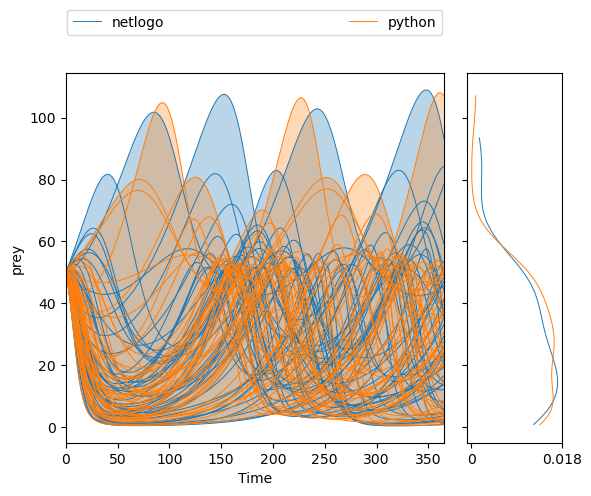

In [82]:
experiments_to_show = np.arange(0, experiments.shape[0], 1)

plt.rcParams['lines.linewidth'] = 0.7

lines(experiments, outcomes, outcomes_to_show='prey', group_by='model',
      show_envelope=True, density=Density.KDE, titles=None, 
      experiments_to_show=experiments_to_show)
plt.show()